# Project 2

##### import needed packages

In [1]:
from tqdm import tqdm_notebook, tqdm, tnrange
from collections import defaultdict, Counter
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from random import shuffle
import random
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import subprocess
import sys
np.set_printoptions(threshold=np.nan)

Global for enabling GPU

In [2]:
run_gpu = torch.cuda.is_available()
run_gpu

True

# Classes and Functions

## Data Manipulation

### Cleaning and preprocessing

In [3]:
def preprocess(train_data, val_data, test_data, vocab_size=10000):
    
    # loop over all the given files
    for data in [train_data, val_data, test_data]:
        # contains a source and a target file
        for k,v in data.items():
            tokenized_path = v[:v.find('.')] + '_tokenized.{}'.format(k)

            # Tokenize 
            tokenize_command = 'perl tools/mosesdecoder/scripts/tokenizer/tokenizer.perl -l {lang} < {file_path} > {output_path}'.format(
                lang=k, file_path=v, output_path=tokenized_path)
            print('tokenize command:\t{}'.format(tokenize_command))
            
            # Lowercase
            lowercase_path = tokenized_path[:tokenized_path.find('.')] + '_lowercased.{}'.format(k)
            lowercase_command = 'perl tools/mosesdecoder/scripts/tokenizer/lowercase.perl < {file_path} > {output_path}'.format(
                file_path=tokenized_path, output_path=lowercase_path)
            print('lowercase command:\t{}\n'.format(lowercase_command))
            
    # BPE
    # Get vocabulary using train data
    script_name = 'python tools/subword-nmt/subword_nmt/learn_joint_bpe_and_vocab.py'
    args = ' --input {train_en} {train_fr} -s {num_symbols} -o {codes_file} --write-vocabulary {vocab_file}.en {vocab_file}.fr'
    substr_index = train_data['en'].find('/')
    vocab_file_name = train_data['en'][:substr_index] + '/vocab'
    codes_file_name = train_data['en'][:substr_index] + '/codes.bpe'
    learn_vocab_command = script_name + args.format(
        train_en='data/train/train_tokenized_lowercased.en',
        train_fr='data/train/train_tokenized_lowercased.fr',
        num_symbols=str(vocab_size),
        codes_file=codes_file_name,
        vocab_file=vocab_file_name
    )
    print('learn vocab command:\t{}'.format(learn_vocab_command))
    
    # Process all files the same way for consistency
    script_name = 'python tools/subword-nmt/subword_nmt/apply_bpe.py'
    for data in [train_data, val_data, test_data]:
        for k,v in data.items():
            args = ' -c {codes_file} --vocabulary {vocab_file}.{lang} --vocabulary-threshold 1 < {train_file}.{lang} > {train_file}_bpe.{lang}'
            train_file_name = v[:v.find('.')] + '_tokenized_lowercased'
            bpe_command = script_name + args.format(
                codes_file=codes_file_name,
                vocab_file=vocab_file_name,
                lang=k,
                train_file=train_file_name
            )
            print('bpe command:\t{}'.format(bpe_command))

### Building dictionaries and vocabularies

In [4]:
PAD = '<PAD>'
UNK = '<UNK>'
START = '<SOS>'
END = '<EOS>'

In [5]:
class DataProcessor():
    def __init__(self, file_name, vocab_size):
        self.max_sentence_length = -1
        self.vocab_size = vocab_size
        
        self.file_name = file_name
        self.sentences = self.load_data()
        self.vocab,self.vocab_size, self.vocab_weight = self.build_vocab()
        self.w2i, self.i2w = self.build_dicts()
        
    def load_data(self):
        sentences = []
        with open(self.file_name, 'r', encoding='utf-8') as f:
            for line in f:
                sentences.append(line.split())                
        return sentences
    
    def build_dicts(self):
        """
        creates lookup tables to find the index given the word 
        and the otherway around 
        """
        w2i = defaultdict(lambda: w2i[UNK])
        i2w = dict()
        for i,w in enumerate(self.vocab):
            i2w[i] = w
            w2i[w] = i
        return w2i, i2w    
    
    def build_vocab(self): 
        """
        builds a vocabulary with the most occuring words, in addition to
        the UNK token at index 1 and PAD token at index 0. 
        START and END tokens are added to the vocabulary through the
        preprocessed sentences.
        with vocab size none, all existing words in the data are used
        """
        vocab = Counter()
        for s in self.sentences:
            l = len(s)
            if l > self.max_sentence_length:
                self.max_sentence_length = l
            for w in s:
                vocab[w] += 1

        vocab = [k for k,_ in vocab.most_common(self.vocab_size)]
        vocab_weights = list(range(len(vocab)))
        vocab = [PAD,UNK,START,END] + vocab
        vocab_weights = [0.,1.,1.,1.] + vocab_weights
        return vocab,len(vocab), vocab_weights 

### Getting data batches

In [6]:
def batch_generator(source_processor, target_processor, batch_size):
    idx = np.arange(len(source_processor.sentences))
        
    if batch_size == 1:
        bi = 0
        while True:
            b_words_source = np.zeros([batch_size, source_processor.max_sentence_length+1])
            b_positions_source = np.zeros([batch_size, source_processor.max_sentence_length+1])
            b_words_target = np.zeros([batch_size, target_processor.max_sentence_length+2])
            
            sent_source = source_processor.sentences[bi] + [END]
            sent_target = [START] + target_processor.sentences[bi] + [END]
                
            b_words_source[0, :len(sent_source)] = np.array([source_processor.w2i[w] for w in sent_source])
            b_positions_source[0, :len(sent_source)] = np.array([i for i in range(len(sent_source))])
            b_words_target[0, :len(sent_target)] = np.array([target_processor.w2i[w] for w in sent_target])
            
            if run_gpu:
                word_tens = torch.from_numpy(b_words_source).type(torch.cuda.LongTensor)
                pos_tens = torch.from_numpy(b_positions_source).type(torch.cuda.LongTensor)
                tar_tens = torch.from_numpy(b_words_target).type(torch.cuda.LongTensor)
                sentence_lengths_source = torch.cuda.FloatTensor([len(sent_source)])
                sentence_lengths_target = torch.cuda.FloatTensor([len(sent_target)])
            else:
                word_tens = torch.from_numpy(b_words_source).type(torch.LongTensor)
                pos_tens = torch.from_numpy(b_positions_source).type(torch.LongTensor)
                tar_tens = torch.from_numpy(b_words_target).type(torch.LongTensor)
                sentence_lengths_source = torch.FloatTensor([len(sent_source)])
                sentence_lengths_target = torch.FloatTensor([len(sent_target)])
                
            bi += 1
            if bi == len(source_processor.sentences):
                bi = 0
            yield (word_tens,
                   pos_tens,
                   tar_tens,
                   sentence_lengths_source,
                   sentence_lengths_target,
                   np.ones(sentence_lengths_source[0]),
                   np.ones(sentence_lengths_target[0]))
    
    else:
        seed = 0
        while True:
            epoch = list(idx)
            random.Random(seed).shuffle(epoch)
            
            #loop over the number of batches in the dataset
            for b in range(int(np.floor(len(idx)/batch_size))):
                b_words_source = np.zeros([batch_size, source_processor.max_sentence_length+1])
                b_positions_source = np.zeros([batch_size, source_processor.max_sentence_length+1])
                b_words_target = np.zeros([batch_size, target_processor.max_sentence_length+2])
                
                sentence_lengths_source = []
                sentence_lengths_target = []
                #fill the batch with sentence
                for i in range(batch_size):
                    # pick a sentence from the current epoch
                    bi = epoch.pop() 
                    sent_source = source_processor.sentences[bi] + [END]
                    sent_target = [START] + target_processor.sentences[bi] + [END]

                    b_words_source[i, :len(sent_source)] = np.array([source_processor.w2i[w] for w in sent_source])
                    b_positions_source[i, :len(sent_source)] = np.array([i for i in range(len(sent_source))])
                    b_words_target[i, :len(sent_target)] = np.array([target_processor.w2i[w] for w in sent_target])

                    sentence_lengths_source.append(len(sent_source))
                    sentence_lengths_target.append(len(sent_target))
                
                b_words_source = b_words_source[:,:np.max(sentence_lengths_source)]
                b_positions_source = b_positions_source[:,:np.max(sentence_lengths_source)]
                b_words_target = b_words_target[:,:np.max(sentence_lengths_target)]
                
                if run_gpu:
                    word_tens = torch.from_numpy(b_words_source).type(torch.cuda.LongTensor)
                    pos_tens = torch.from_numpy(b_positions_source).type(torch.cuda.LongTensor)
                    tar_tens = torch.from_numpy(b_words_target).type(torch.cuda.LongTensor)
                    sentence_lengths_source = torch.cuda.FloatTensor(sentence_lengths_source)
                    sentence_lengths_target = torch.cuda.FloatTensor(sentence_lengths_target)
                    source_mask = torch.from_numpy((b_words_source > 0).astype(int)).type(torch.cuda.FloatTensor)
                    target_mask = torch.from_numpy((b_words_target > 0).astype(int)).type(torch.cuda.FloatTensor)
                else:
                    word_tens = torch.from_numpy(b_words_source).type(torch.LongTensor)
                    pos_tens = torch.from_numpy(b_positions_source).type(torch.LongTensor)
                    tar_tens = torch.from_numpy(b_words_target).type(torch.LongTensor)
                    sentence_lengths_source = torch.FloatTensor(sentence_lengths_source)
                    sentence_lengths_target = torch.FloatTensor(sentence_lengths_target)
                    source_mask = torch.from_numpy((b_words_source > 0).astype(int)).type(torch.FloatTensor)
                    target_mask = torch.from_numpy((b_words_target > 0).astype(int)).type(torch.FloatTensor)

                yield (word_tens,
                       pos_tens,
                       tar_tens,
                       sentence_lengths_source,
                       sentence_lengths_target,
                       source_mask,
                       target_mask)

## Sequence 2 Sequence RNN's

### Encoder

In [29]:
class Encoder(nn.Module):
    def __init__(self, source_vocab_size, source_max_length, embeddings_dim, use_encoder_rnn):
        super().__init__()
        self.embeddings_dim = embeddings_dim
        self.word_embeddings = nn.Embedding(source_vocab_size, embeddings_dim)
        self.pos_embeddings = nn.Embedding(source_max_length, embeddings_dim)
        self.gru = nn.GRU(embeddings_dim, embeddings_dim, bidirectional=True)
        
    def forward(self, words_batch, pos_batch, sentence_lengths, mask): # all inputs are tensors
        batch_size = words_batch.size(0)
        encoded_length = words_batch.size(1)
        if use_encoder_rnn:
            words_emb = self.word_embeddings(words_batch)
            output, hn = self.gru(words_emb.view(encoded_length,batch_size,self.embeddings_dim))
            last_out = output[-1,:,:]
            return output, last_out
        else:
            words_emb = self.word_embeddings(words_batch)
            pos_emb = self.pos_embeddings(pos_batch)
            full_emb = torch.cat((words_emb,pos_emb), dim=-1)
            mean_emb = full_emb.mul(mask.unsqueeze(2).expand_as(full_emb)).sum(dim=1).float()
            mean_emb = mean_emb.div(sentence_lengths.float().view(-1,1)).squeeze(1) # batched version of torch.mean(full_emb,1)
            return full_emb.view(encoded_length,batch_size,self.embeddings_dim*2), mean_emb

### Decoder

In [8]:
class Decoder(nn.Module):
    def __init__(self, target_vocab_size, embeddings_dim, dropout_p=0.5):
        super().__init__()
        
        self.embedding_dim = embedding_dims
        
        self.target_embeddings = nn.Embedding(target_vocab_size, embeddings_dim)
        self.droput = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embeddings_dim, embeddings_dim*2) # gru is similar to LSTM, and has 2 outputs
        self.concat = nn.Linear(embeddings_dim*4, embeddings_dim*4)
        self.logit_lin = nn.Linear(embeddings_dim*4, target_vocab_size) # out
        
    def forward(self, gold_words_batch, hidden_batch, stacked_encoded_words_batch, use_attention=True, run_gpu=run_gpu):
        batch_size = gold_words_batch.size(0)
        encoded_length = stacked_encoded_words_batch.size(0)
        
        emb = self.target_embeddings(gold_words_batch)
        emb = self.droput(emb)
        
        gru_output, hidden = self.gru(emb.view(1,batch_size,self.embedding_dim), hidden_batch)

        if use_attention:
            # attention 
            # dot product
            alphas = hidden_batch.view(batch_size, 1, self.embedding_dim*2).bmm(
                                stacked_encoded_words_batch.view(batch_size, self.embedding_dim*2, encoded_length)) # batched version of dot product

            # Turn to probability distribution
            alphas = F.softmax(alphas, dim=2)
        else:
            alphas = torch.ones(batch_size, 1, encoded_length)
            if run_gpu:
                alphas = alphas.cuda()
        
        # context is weights x hidden states from encoder
        context = torch.bmm(alphas, stacked_encoded_words_batch.view(batch_size,encoded_length,self.embedding_dim*2))
        concat_input = torch.cat((gru_output.view(batch_size,1,self.embedding_dim*2), context),dim=-1)
        concat_output = F.tanh(self.concat(concat_input))
        output = self.logit_lin(concat_output)

        return output, hidden, alphas

### Encoder Decoder

In [9]:
class EncoderDecoder(nn.Module):
    def __init__(self, 
                 embeddings_dim,
                 source_vocab_size, 
                 source_max_length, 
                 target_vocab_size, 
                 dropout_p=0.1,
                 teacher_forcing_p=1,
                 use_encoder_rnn=True):
        
        super().__init__()
        
        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size
        self.teacher_forcing_p = teacher_forcing_p
        
        self.encoder = Encoder(source_vocab_size,
                               source_max_length + 1, 
                               embeddings_dim,
                               use_encoder_rnn=use_encoder_rnn)
        self.decoder = Decoder(target_vocab_size, 
                               embeddings_dim,
                               dropout_p=dropout_p)

        self.loss = nn.CrossEntropyLoss(ignore_index=0, reduce=False)

        if run_gpu:
            self.encoder = self.encoder.cuda()
            self.decoder = self.decoder.cuda()
            self.loss = self.loss.cuda()

    def forward(self, 
                words_batch_source,
                pos_batch_source,
                sentence_length_source,
                words_batch_target,
                sentence_lengths_target,
                source_mask,
                target_mask):        
        
        # Encode
        all_embs, hidden_state_batch = self.encoder(words_batch_source, 
                                                    pos_batch_source, 
                                                    sentence_length_source, 
                                                    source_mask)
        # Decode
        batch_size, max_sent_len = words_batch_target.shape
        out = torch.zeros((batch_size))
        
        if run_gpu:
            out = out.cuda()
            
        teacher_forcing = np.random.random() <= self.teacher_forcing_p
        hidden_state_batch = hidden_state_batch.unsqueeze(0)
        # w_idx goes from START to final word, which are inputs for decoder
        if teacher_forcing:
            for w_idx in range(max_sent_len-1):
                # prediction = (Batch_size,1,Vocab_size), word_batch_target[:,w_idx+1] = (Batch_size), where 0 <= value <= vocab_size
                prediction, hidden_state_batch, _ = self.decoder(words_batch_target[:,w_idx].view(-1,1), 
                                                              hidden_state_batch,
                                                              all_embs)
                out += self.loss(prediction.squeeze(1), words_batch_target[:,w_idx+1]) #given the current word, we predict the next word      
        else:
            prediction = words_batch_target[:,0].view(-1,1)
            for w_idx in range(max_sent_len-1):
                prediction, hidden_state_batch, _ = self.decoder(prediction, 
                                                                 hidden_state_batch,
                                                                 all_embs)
                out += self.loss(prediction.squeeze(1), words_batch_target[:,w_idx+1]) #given the current word, we predict the next word 
                
                index_predicted_word = np.argmax(prediction.detach().cpu().numpy(), axis=2)
                prediction = torch.LongTensor([index_predicted_word]).view(-1,1)
                
                if prediction == 3: # EOS
                    break
                    
                if run_gpu:
                    prediction = prediction.cuda()
    
        #cleanup
        del(all_embs)
        del(hidden_state_batch)
        out = torch.mean(torch.div(out,sentence_lengths_target))  # the loss is the average of losses, so divide over number of words in each sentence
        
        return out

# Running the Code

## Define Hyper Parameters

#### files

In [10]:
# Raw
train_data = {'en': 'data/train/train.en', 'fr': 'data/train/train.fr'}
val_data = {'en': 'data/val/val.en', 'fr': 'data/val/val.fr'}
test_data = {'en': 'data/test/test_2017_flickr.en', 'fr': 'data/test/test_2017_flickr.fr'}

# Preprocessed
source_train_file = 'data/train/train_tokenized_lowercased_bpe.fr'
target_train_file = 'data/train/train_tokenized_lowercased_bpe.en'
source_val_file = 'data/val/val_tokenized_lowercased_bpe.fr'
target_val_file = 'data/val/val_tokenized_lowercased_bpe.en'
source_test_file = 'data/test/test_2017_flickr_tokenized_lowercased_bpe.fr'
target_test_file = 'data/test/test_2017_flickr_tokenized_lowercased_bpe.en'

#### Network Parameters

In [11]:
learning_rate = 1e-1
max_epochs = 30
batch_size = 16

source_vocab_size = 30000
target_vocab_size = 30000
hidden_dims = 128
embedding_dims = 128

save_step = 100

use_encoder_rnn = False # change accordingly

## process data

perform the preprocessing

In [12]:
preprocess(train_data, val_data, test_data, source_vocab_size)

prepare data for the model

In [13]:
source_processor = DataProcessor(source_train_file, source_vocab_size)
target_processor = DataProcessor(target_train_file, target_vocab_size)
source_processor_val = DataProcessor(source_val_file, None)
target_processor_val = DataProcessor(target_val_file, None)

## setup the Network

In [14]:
encdec = EncoderDecoder(embedding_dims, 
                        source_processor.vocab_size,
                        source_processor.max_sentence_length,
                        target_processor.vocab_size,
                        use_encoder_rnn=use_encoder_rnn)

if run_gpu:
    encdec = encdec.cuda()
encdec.train(True) #probably not needed. better to be safe
opt = SGD(encdec.parameters(), lr=learning_rate)

In [15]:
def validation_predictions(model, prediction_file_name):
    run_gpu = False
    # Use submodules for prediction
    encoder = model.encoder.cpu()
    decoder = model.decoder.cpu()

    predicted_sentences = []

    for s,ts in zip(source_processor_val.sentences,target_processor_val.sentences):
        mask = torch.from_numpy(np.ones([1,len(s)])).type(torch.FloatTensor)
        words_tokens = torch.LongTensor([source_processor.w2i[w] for w in s])
        words_tokens_tar = torch.LongTensor([target_processor.w2i[w] for w in ts])
        pos_tokens = torch.LongTensor([i for i in range(len(s))])
        len_s = torch.FloatTensor([len(s)])
        
        # Encode
        all_embs, mean_emb = encoder(words_tokens.view(1, len(s)),
                                     pos_tokens.view(1, len(s)), 
                                     len_s,
                                     mask)
        del(mask)
        del(len_s)
        del(pos_tokens)
        del(words_tokens)

        # Decode
        start_token = torch.LongTensor([target_processor.w2i[START]])
        predicted_words = []
        
        prediction = start_token.view(1,1)
        hidden_state_batch = mean_emb

        hidden_state_batch = hidden_state_batch.unsqueeze(0)
        for w_idx in range(target_processor.max_sentence_length):# loop until EOS is produced or a max is reached (max_sentence_length)
            prediction, hidden_state_batch,_ = decoder(prediction, # the previous prediction
                                                       hidden_state_batch,
                                                       all_embs,
                                                       run_gpu=run_gpu)

            index_predicted_word = np.argmax(prediction.detach().numpy(), axis=2)[0][0]
            predicted_word = target_processor.i2w[index_predicted_word]
            predicted_words.append(predicted_word)

            if predicted_word == END:
                break
            
            prediction = torch.LongTensor([index_predicted_word]).view(1,1)
        
        predicted_sentences.append(predicted_words)

        del(start_token)
        del(mean_emb)
        del(hidden_state_batch)
        del(all_embs)
        del(prediction)
    
    with open(prediction_file_name, 'w', encoding='utf-8') as f:
        for p in predicted_sentences:
            if p[-1] == END:
                p = p[:-1]
            f.write(' '.join(p) + '\n')
    
    # execute a powershell script for removing tokens
    prediction_restored = prediction_file_name[:-5] + '_restored.pred'
    _ = %ps get-content {prediction_file_name} | %{{$$_ -replace "(@@ )|(@@ ?$)",""}} | out-file {prediction_restored} -encoding Ascii
    perl_script = subprocess.Popen(["C:/Strawberry/perl/bin/perl.exe", 
                                    "./tools/mosesdecoder/scripts/generic/multi-bleu.perl", 
                                    "-lc", 
                                    "./data/val/val_tokenized_lowercased.en",
                                    "<",prediction_restored],
                                   shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    bleu_out,bleu_err = perl_script.communicate()
    run_gpu=True
    return bleu_out.decode("utf-8"), bleu_err.decode("utf-8")

## training

In [16]:
losses = []
count = 0
pseudo_epoch = 0
gen = batch_generator(source_processor, target_processor, batch_size)
sentences_in_data = len(source_processor.sentences)
iterations = int(np.ceil(sentences_in_data/batch_size)*max_epochs)
    
for it in tnrange(iterations): 
    output_i = it%save_step
    out = 0
    if output_i == 0:
        if it != 0:
            losses += output.tolist()
            del(output)
        if run_gpu:
            output = torch.cuda.FloatTensor([0]*save_step)
        else:
            output = torch.FloatTensor([0]*save_step)
    
    opt.zero_grad()
    
    # Get the next bath of data and 
    (words_batch_source, 
    pos_batch_source,
    words_batch_target,
    sentence_lengths_source,
    sentence_lengths_target,
    source_mask,
    target_mask) = next(gen)
    
    out = encdec(words_batch_source,
                 pos_batch_source, 
                 sentence_lengths_source, 
                 words_batch_target, 
                 sentence_lengths_target, 
                 source_mask, 
                 target_mask)
    
    out.backward()
    output[output_i] = out
    opt.step()
    count += batch_size
    if count >= sentences_in_data:
        encdec.train(False)
        count = 0
        pseudo_epoch += 1
        #perform validation
        timestamp = datetime.now()
        prediction_file_name = 'val_epoch_{}_encmean_model_it_{}_t_{:%m_%d_%H_%M}.pred'.format(pseudo_epoch, it, timestamp)
        blue,_ = validation_predictions(encdec,prediction_file_name)
        print("Pseudo-Epoch {}:\t{}".format(pseudo_epoch,blue.strip()))
        # Dump trained models
        torch.save(encdec.state_dict(), 'encmean_model_it_{}_t_{:%m_%d_%H_%M}.torchsave'.format(it, timestamp))
        if run_gpu:
            encdec = encdec.cuda()
        encdec.train(True)
losses += output.tolist()[:output_i+1]
del(output)

# Dump trained models
timestamp = datetime.now()
last_model_file_name = 'encmean_model_last-it_{}_t_{:%m_%d_%H_%M}.torchsave'.format(it, timestamp)
torch.save(encdec.state_dict(), last_model_file_name)

print('Model saved in file: {}'.format(last_model_file_name))

Pseudo-Epoch 1:	BLEU = 0.60, 5.3/1.1/0.2/0.1 (BP=1.000, ratio=4.804, hyp_len=63928, ref_len=13308)
Pseudo-Epoch 2:	BLEU = 3.02, 26.6/5.2/1.2/0.5 (BP=1.000, ratio=1.150, hyp_len=15309, ref_len=13308)
Pseudo-Epoch 3:	BLEU = 3.36, 28.0/5.7/1.5/0.5 (BP=1.000, ratio=1.162, hyp_len=15465, ref_len=13308)
Pseudo-Epoch 4:	BLEU = 3.33, 27.3/5.7/1.5/0.5 (BP=1.000, ratio=1.261, hyp_len=16776, ref_len=13308)
Pseudo-Epoch 5:	BLEU = 4.00, 32.7/6.7/1.8/0.6 (BP=1.000, ratio=1.027, hyp_len=13665, ref_len=13308)
Pseudo-Epoch 6:	BLEU = 4.28, 32.9/6.9/2.0/0.8 (BP=1.000, ratio=1.056, hyp_len=14047, ref_len=13308)
Pseudo-Epoch 7:	BLEU = 4.42, 30.5/6.8/2.1/0.9 (BP=1.000, ratio=1.180, hyp_len=15706, ref_len=13308)
Pseudo-Epoch 8:	BLEU = 4.70, 32.5/7.2/2.1/1.0 (BP=1.000, ratio=1.138, hyp_len=15143, ref_len=13308)
Pseudo-Epoch 9:	BLEU = 5.01, 34.7/7.9/2.4/1.0 (BP=1.000, ratio=1.073, hyp_len=14285, ref_len=13308)
Pseudo-Epoch 10:	BLEU = 5.36, 36.8/8.5/2.6/1.0 (BP=0.997, ratio=0.997, hyp_len=13271, ref_len=13308)


Plot losses

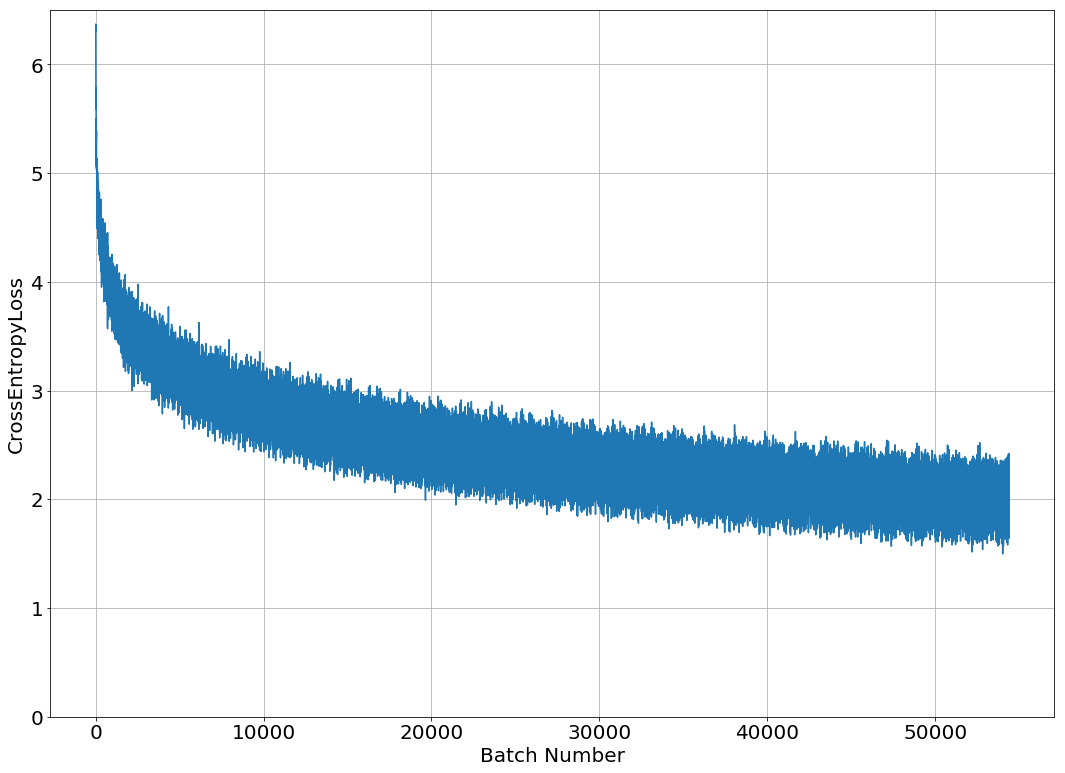

In [104]:
plt.figure(figsize=(18,13))
plt.plot(range(len(losses)),losses)
plt.tick_params(labelsize=20)
plt.ylim(0,6.5)
# plt.xlim(0)
plt.xlabel('Batch Number',size=20)
plt.ylabel('CrossEntropyLoss',size=20)
plt.grid()
plt.show()

## prediction

load trained models

In [34]:
run_gpu = False
use_encoder_rnn

False

In [35]:
encdec = EncoderDecoder(embedding_dims,
                        source_processor.vocab_size,
                        source_processor.max_sentence_length,
                        target_processor.vocab_size)

trained_model_file = last_model_file_name

saved_state = torch.load(trained_model_file, map_location=lambda storage, loc: storage) # Bring from cuda
encdec.load_state_dict(saved_state)

# Use submodules for prediction
encoder = encdec.encoder
decoder = encdec.decoder

In [36]:
file_id = trained_model_file[trained_model_file.rfind('/')+1:-10]
prediction_file_name = 'test_{}.pred'.format(file_id)
prediction_file_name

'test_encmean_model_last-it_54389_t_05_27_19_37.pred'

In [37]:
source_processor_test = DataProcessor(source_test_file, None)
target_processor_test = DataProcessor(target_test_file, None)

In [39]:
predicted_sentences = []
attention_weights = [] # list of (source_sentence, predicted_sentence, alphas) items

for s in source_processor_test.sentences:
    mask = torch.from_numpy(np.ones([1,len(s)])).type(torch.FloatTensor)
    words_tokens = torch.LongTensor([source_processor.w2i[w] for w in s])
    pos_tokens = torch.LongTensor([i for i in range(len(s))])
    
    # Encode
    all_embs, mean_emb = encoder(words_tokens.view(1, len(s)),
                                 pos_tokens.view(1, len(s)), 
                                 torch.FloatTensor([len(s)]),
                                 mask)
    
    # Decode
    predicted_words = []
    weights = []
    
    start_token = torch.LongTensor([target_processor.w2i[START]])
    prediction = start_token.view(1,1)
    
    hidden_state_batch = mean_emb.unsqueeze(0)
    
    for w_idx in range(target_processor.max_sentence_length):# loop until EOS is produced or a max is reached (max_sentence_length)
        prediction, hidden_state_batch, alphas = decoder(
            prediction, # the previous prediction
            hidden_state_batch,
            all_embs,run_gpu=run_gpu)
        
        index_predicted_word = np.argmax(prediction.detach().numpy(), axis=2)[0][0]
        predicted_word = target_processor.i2w[index_predicted_word]
        predicted_words.append(predicted_word)
        weights.append(alphas.view(-1).tolist())
        if predicted_word == END:
            break
            
        prediction = torch.LongTensor([index_predicted_word]).view(1,1)
    
    predicted_sentences.append(predicted_words)
    attention_weights.append((s, predicted_words, np.array(weights)))
    
with open(prediction_file_name, 'w', encoding='utf-8') as f:
    for p in predicted_sentences:
        if p[-1] == END:
            p = p[:-1]
        f.write(' '.join(p) + '\n')

print('Predictions ready in file: {}'.format(prediction_file_name))

pickle.dump(attention_weights, open('attention_weights_meanenc_prediction_weights.p','wb'))

Predictions ready in file: test_encmean_model_last-it_54389_t_05_27_19_37.pred


### attention visualization

In [ ]:
# Load attention weights from the best model
attention_weights = pickle.load(open('attention_weights_meanenc_prediction_weights.p', 'rb'))

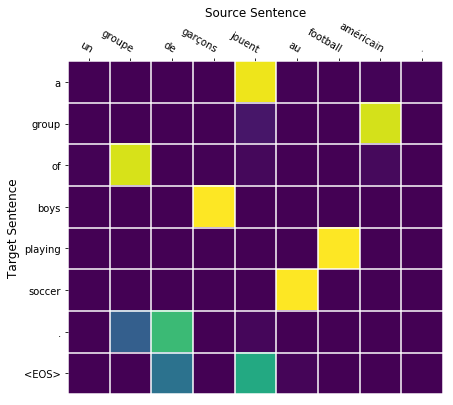

In [146]:
def visualize_attention(source_sentence, target_sentence, weights):
    l_s = len(source_sentence)
    l_t = len(target_sentence)
    fig, ax = plt.subplots(figsize=(l_t*0.8,l_s*0.8))
    im = ax.imshow(weights)
    #show the labels for every tick
    ax.set_xticks(np.arange(l_s))
    ax.set_yticks(np.arange(l_t))
    ax.set_xticklabels(source_sentence)
    ax.set_yticklabels(target_sentence)
    ax.set_xlabel('Source Sentence', fontsize='large')
    ax.set_ylabel('Target Sentence', fontsize='large')
    ax.xaxis.set_label_position('top') 
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")
     # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xticks(np.arange(l_s+1)-.5, minor=True)
    ax.set_yticks(np.arange(l_t+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1.5)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    plt.show()
#     plt.savefig('{}_pred'.format(file_id))
  

# Choose a short sentence
# short_translations = []
# for sentence_id, (src, tgt, w) in enumerate(attention_weights):
#     if len(src) < 10:
#         short_translations.append((src, tgt, sentence_id))

# for x,y,z in short_translations[:100]:
#     print(x)
#     print(y)
#     print(z)

sentence_id =654
item = attention_weights[sentence_id]
visualize_attention(item[0], item[1], item[2])

## Evaluation

Restore original segmentation

In [151]:
file_id = 'beam5'
prediction_restored = 'beam5_restored.pred'
# prediction_restored = prediction_file_name[:-5] + '_restored.pred'

In [42]:
# sed -r 's/(@@ )|(@@ ?$)//g' Use the Powershell version instead. Watch for ASCII!

restore_command = 'get-content {input_file} | %{{$_ -replace "(@@ )|(@@ ?$)",""}} | out-file {output_file} -encoding ASCII'.format(
    input_file = prediction_file_name,
    output_file = prediction_restored)

print('restore file command:\t', restore_command)

restore file command:	 get-content test_encmean_model_last-it_54389_t_05_27_19_37.pred | %{$_ -replace "(@@ )|(@@ ?$)",""} | out-file test_encmean_model_last-it_54389_t_05_27_19_37_restored.pred -encoding ASCII


In [43]:
%ps get-content {prediction_file_name} | %{{$$_ -replace "(@@ )|(@@ ?$)",""}} | out-file {prediction_restored} -encoding Ascii
#| %\{\{$_ -replace "(@@ )|(@@ ?$)",""\}\} | out-file {prediction_restored} -encoding ASCII

[]

### BLEU

In [115]:
bleu_script = 'tools/mosesdecoder/scripts/generic/multi-bleu.perl'
bleu_command = 'perl tools/mosesdecoder/scripts/generic/multi-bleu.perl -lc data/test/test_2017_flickr_tokenized_lowercased.en < {} > {} '.format(prediction_restored,
                                                                                                                                              'bleu_results/' + file_id + '.bleu')
bleu_script = 'tools/mosesdecoder/scripts/generic/multi-bleu.perl'
bleu_commands = '-lc data/test/test_2017_flickr_tokenized_lowercased.en < {}'.format(prediction_restored)

# print('bleu file command:\n', bleu_command)

In [ ]:
perl_script = subprocess.Popen(["C:/Strawberry/perl/bin/perl.exe", 
                                "./tools/mosesdecoder/scripts/generic/multi-bleu.perl", 
                                "-lc", 
                                "./data/test/test_2017_flickr_tokenized_lowercased.en",
                                "<",prediction_restored],
                               shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out,err = perl_script.communicate()
out = out.decode("utf-8") 
err = err.decode("utf-8") 
print(out)
print(err)

In [ ]:
prediction_restored

### Meteor

In [152]:
meteor_command = 'java -jar tools/meteor-1.5/meteor-1.5.jar {} data/test/test_2017_flickr_tokenized_lowercased.en > {}'.format(
    prediction_restored,
    'meteor_results/' + file_id + '.meteor')

print('meteor command:\t', meteor_command)

meteor command:	 java -jar tools/meteor-1.5/meteor-1.5.jar beam5_restored.pred data/test/test_2017_flickr_tokenized_lowercased.en > meteor_results/beam5.meteor


In [ ]:
# We're getting an out of memory error when running from the notebook, call from the command line instead

#meteor_script = subprocess.Popen(["java", 
#                                 "-jar", 
#                                 "./tools/meteor-1.5/meteor-1.5.jar",
#                                 prediction_restored,
#                                 "./data/test/test_2017_flickr_tokenized_lowercased.en"],
#                                shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE)
# out,err = meteor_script.communicate()
# out = out.decode("utf-8") 
# err = err.decode("utf-8") 
# print(out)
# print(err)

### TER

Preparation for TER

In [153]:
# Append ids to both gold and prediction files
gold = 'data/test/test_2017_flickr_tokenized_lowercased.en'
gold_ter = gold[:-3] + '_ter.en'

prediction_restored_ter = prediction_restored[:-5] + '_ter.pred'

with open(gold, 'r') as fi, open(gold_ter, 'w') as fo:
    for i, line in enumerate(fi.readlines()):
        last_char = line[-1]
        fo.write('{} ({}){}'.format(line[:-1], i, last_char))

with open(prediction_restored, 'r') as fi, open(prediction_restored_ter, 'w') as fo:
    for i, line in enumerate(fi.readlines()):
        last_char = line[-1]
        fo.write('{} ({}){}'.format(line[:-1], i, last_char))

In [154]:
ter_command = 'java -jar tools/tercom-0.7.25/tercom.7.25.jar -r {} -h {} -n {} > {}'.format(
    gold_ter,
    prediction_restored_ter,
    'ter_results/' + file_id,
    'ter_results/' + file_id + '_out.txt')

print('ter command:\t', ter_command)

ter command:	 java -jar tools/tercom-0.7.25/tercom.7.25.jar -r data/test/test_2017_flickr_tokenized_lowercased_ter.en -h beam5_restored_ter.pred -n ter_results/beam5 > ter_results/beam5_out.txt


#### beam search

In [86]:
class Hypothesis(object):
    """use for decoding"""
    def __init__(self, perm, score, state, sent):
        self.perm = perm
        self.score = score
        self.state = state
        self.sent = sent

    def update(self):
        return

def beamsearch(model, sent, beam_size):
    """Beam search decoder"""
    encoder = model.encoder
    decoder = model.decoder
    
    """bin: keep track of hypothesis, bin[i] contains all the hypotheses of length i"""
    bin = [] # to keep track of hypothesis

    # first of all, we need to encode the whole source sentence
    # since this is done only one time
    # map word to its id
    mask = torch.from_numpy(np.ones([1,len(sent)])).type(torch.FloatTensor)
    words_tokens = torch.LongTensor([source_processor.w2i[w] for w in sent])
    pos_tokens = torch.LongTensor([i for i in range(len(sent))])
    
    # Encode
    all_embs, mean_emb = encoder(words_tokens.view(1, len(sent)),
                                 pos_tokens.view(1, len(sent)), 
                                 torch.FloatTensor([len(sent)]),
                                 mask)
    mean_emb = mean_emb.unsqueeze(0)
    # Decode 
    # create the initial hypothesis
    h0 = Hypothesis([target_processor.w2i[START]], 0.0, mean_emb, [])
    # put h0 to bin
    stacks = []
    stacks.append(h0)
    bin.append(stacks)  # note that we put h0 in to a stack first

    # now we can loop through max number of target words
    for w_idx in range(target_processor.max_sentence_length):
        prev_stack = bin[w_idx]
        curr_stack = []
        for hypo in prev_stack:
            if len(hypo.sent) > 0 and hypo.sent[-1] == END:
                curr_stack.append(hypo)
            else:
                # expand it
                # get the previous generated word in hypo
                prediction = torch.LongTensor([hypo.perm[-1]]).view(1,1)
                # now, update decode
                new_prediction, new_hidden_state_batch, _ = decoder(prediction, # the previous prediction
                                                                    hypo.state,
                                                                    all_embs,run_gpu=run_gpu)
                del(prediction)
                new_prediction = new_prediction.detach().numpy().flatten()
                best_id = new_prediction.argsort()[-beam_size:][::-1]
                # get out top beam_size log prob
                for j in best_id:
                    perm = list(hypo.perm)
                    sent = list(hypo.sent)
                    # extend the permutation
                    perm.append(j)
                    new_prob = hypo.score + new_prediction[j]
                    predicted_word = target_processor.i2w[j]
                    sent.append(predicted_word)
                    new_h = Hypothesis(perm,new_prob,new_hidden_state_batch,sent)
                    curr_stack.append(new_h)

        #if there more then max beam_size permutations, reduce
        if len(curr_stack) > beam_size:
            ordered_scores = []
            #get the scores from the hypothesis
            for h in curr_stack:
                ordered_scores.append(h.score)
            #get the indexs from 100 highest scores
            locations = sorted(range(len(ordered_scores)), key=lambda i: ordered_scores[i])[-beam_size:]
            #put top 100 in the bin
            stacks = [curr_stack[i] for i in locations]
            bin.append(stacks)
        else:
            bin.append(curr_stack)
    # now find the highest scored translation
    ordered_scores = []
    last_stack = bin[-1]
    #get the scores from the hypothesis
    for h in last_stack:
        ordered_scores.append(h.score)
    #return the hypothesis with highest score
    return last_stack[ordered_scores.index(max(ordered_scores))]

# hyp = beamsearch(encdec, source_processor_test.sentences[0], 10)

In [90]:
beam_prediction_file_name = 'beam_'+ prediction_file_name
with open(beam_prediction_file_name, 'w', encoding='utf-8') as f:
    for s in tqdm_notebook(source_processor_test.sentences):
        hyp = beamsearch(encdec, s, 5)
        p = hyp.sent
        if p[-1] == END:
            p = p[:-1]
        f.write(' '.join(p) + '\n')

    

In [91]:
beam_prediction_restored = beam_prediction_file_name[:-5] + '_restored.pred'
%ps get-content {beam_prediction_file_name} | %{{$$_ -replace "(@@ )|(@@ ?$)",""}} | out-file {beam_prediction_restored} -encoding Ascii

[]

In [92]:
perl_script = subprocess.Popen(["C:/Strawberry/perl/bin/perl.exe", 
                                "./tools/mosesdecoder/scripts/generic/multi-bleu.perl", 
                                "-lc", 
                                "./data/test/test_2017_flickr_tokenized_lowercased.en",
                                "<",prediction_restored],
                               shell=True,stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out,err = perl_script.communicate()
out = out.decode("utf-8") 
err = err.decode("utf-8") 
print(out)
print(err)

BLEU = 5.27, 35.3/8.4/2.7/1.0 (BP=1.000, ratio=1.060, hyp_len=12064, ref_len=11376)

It is in-advisable to publish scores from multi-bleu.perl.  The scores depend on your tokenizer, which is unlikely to be reproducible from your paper or consistent across research groups.  Instead you should detokenize then use mteval-v14.pl, which has a standard tokenization.  Scores from multi-bleu.perl can still be used for internal purposes when you have a consistent tokenizer.

